In [152]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

print("✅ Libraries loaded and NLTK data downloaded silently!")



✅ Libraries loaded and NLTK data downloaded silently!


In [153]:
# Load dataset with proper encoding
df = pd.read_csv('sentiment.csv', encoding='latin-1')

# Use only relevant columns
df = df[['text', 'sentiment']]

# Check first rows
df.head()


,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [154]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean text
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Check cleaned data
df.head()


,text,sentiment,cleaned_text
0,Last session of the day http://twitpic.com/67ezh,neutral,last session day httptwitpiccomezh
1,Shanghai is also really exciting (precisely -...,positive,shanghai also really exciting precisely skyscr...
2,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho quit compan...
3,happy bday!,positive,happy bday
4,http://twitpic.com/4w75p - I like it!!,positive,httptwitpiccomwp like


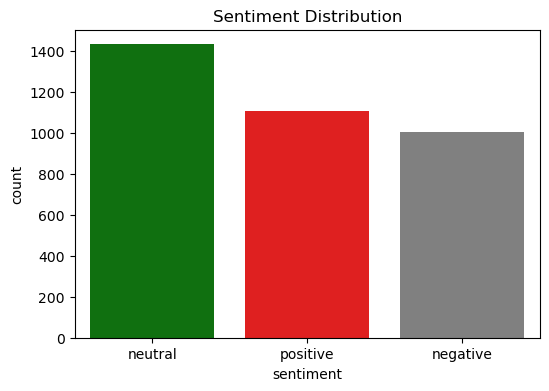

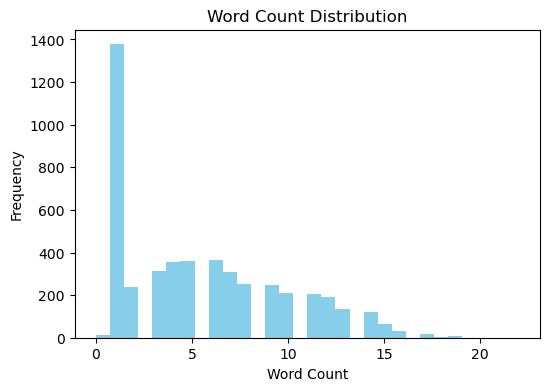

In [155]:
# Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, palette=['green','red','gray'])
plt.title('Sentiment Distribution')
plt.show()

# Word count distribution
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
df['word_count'].plot(kind='hist', bins=30, color='skyblue')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


In [156]:
# ----- Clean text & remove empty rows -----
df = df[df['cleaned_text'].str.strip().astype(bool)]
df = df[df['sentiment'].notnull()]  # Remove rows with NaN sentiment
df['sentiment'] = df['sentiment'].astype(str)  # Ensure all are strings

# ----- TF-IDF Vectorization -----
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text']).toarray()

# ----- Encode labels -----
encoder = LabelEncoder()
y = encoder.fit_transform(df['sentiment'])
class_names = list(map(str, encoder.classes_))  # Ensure target_names are strings

print("✅ Data cleaned and vectorized!")
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)
print("Classes:", class_names)

# ----- Train-Test Split & Model -----
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"📊 Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Show few predictions
print("\nSample Predictions:")
for i in range(5):
    tweet = df['text'].iloc[i][:60]
    pred = encoder.inverse_transform([model.predict(vectorizer.transform([df['cleaned_text'].iloc[i]]))[0]])[0]
    print(f"Tweet: {tweet}...\nPredicted Sentiment: {pred}\n----")


✅ Data cleaned and vectorized!
Feature matrix shape: (3523, 5000)
Labels shape: (3523,)
Classes: ['negative', 'neutral', 'positive']
📊 Accuracy: 0.6596

Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.47      0.57       190
     neutral       0.57      0.79      0.66       278
    positive       0.79      0.66      0.72       237

    accuracy                           0.66       705
   macro avg       0.70      0.64      0.65       705
weighted avg       0.69      0.66      0.66       705


Sample Predictions:
Tweet: Last session of the day  http://twitpic.com/67ezh...
Predicted Sentiment: neutral
----
Tweet:  Shanghai is also really exciting (precisely -- skyscrapers ...
Predicted Sentiment: positive
----
Tweet: Recession hit Veronique Branquinho, she has to quit her comp...
Predicted Sentiment: negative
----
Tweet:  happy bday!...
Predicted Sentiment: positive
----
Tweet:  http://twitpic.com/4w75p - I like it!!...
Predicte

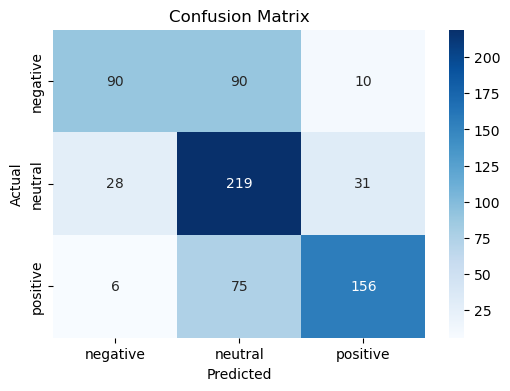

✅ Confusion matrix displayed successfully!


In [157]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("✅ Confusion matrix displayed successfully!")



In [158]:
# Function for preprocessing user input
def preprocess_input(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Function to predict sentiment
def predict_sentiment(tweet):
    cleaned = preprocess_input(tweet)
    vectorized = vectorizer.transform([cleaned]).toarray()
    prediction = model.predict(vectorized)
    sentiment = encoder.inverse_transform(prediction)
    return sentiment[0]

# Example tweets (bypass input() for Jupyter-friendly output)
sample_tweets = [
    "I love this product, it's amazing!",
    "This is the worst experience ever.",
    "I feel okay about the service."
]

for tweet in sample_tweets:
    result = predict_sentiment(tweet)
    print(f"Tweet: {tweet}\nPredicted Sentiment: {result}\n----")


Tweet: I love this product, it's amazing!
Predicted Sentiment: positive
----
Tweet: This is the worst experience ever.
Predicted Sentiment: negative
----
Tweet: I feel okay about the service.
Predicted Sentiment: negative
----
